In [ ]:
# Install yfinance if not already installed
!pip install yfinance --quiet

# Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download historical stock data (Apple as default)
stock_symbol = 'AAPL'  # Change this to any stock symbol (e.g., MSFT, TSLA)
start_date = '2018-01-01'
end_date = '2024-12-31'

# Download data
df = yf.download(stock_symbol, start=start_date, end=end_date)

# Preview first few rows
df.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2018-01-02  40.426823  40.436212  39.722768  39.933986  102223600
2018-01-03  40.419788  40.964259  40.356426  40.490195  118071600
2018-01-04  40.607529  40.710791  40.384579  40.492532   89738400
2018-01-05  41.069859  41.156691  40.612224  40.703751   94640000
2018-01-08  40.917320  41.213022  40.818749  40.917320   82271200

MultiIndex([(  'Date',     ''),
            ( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


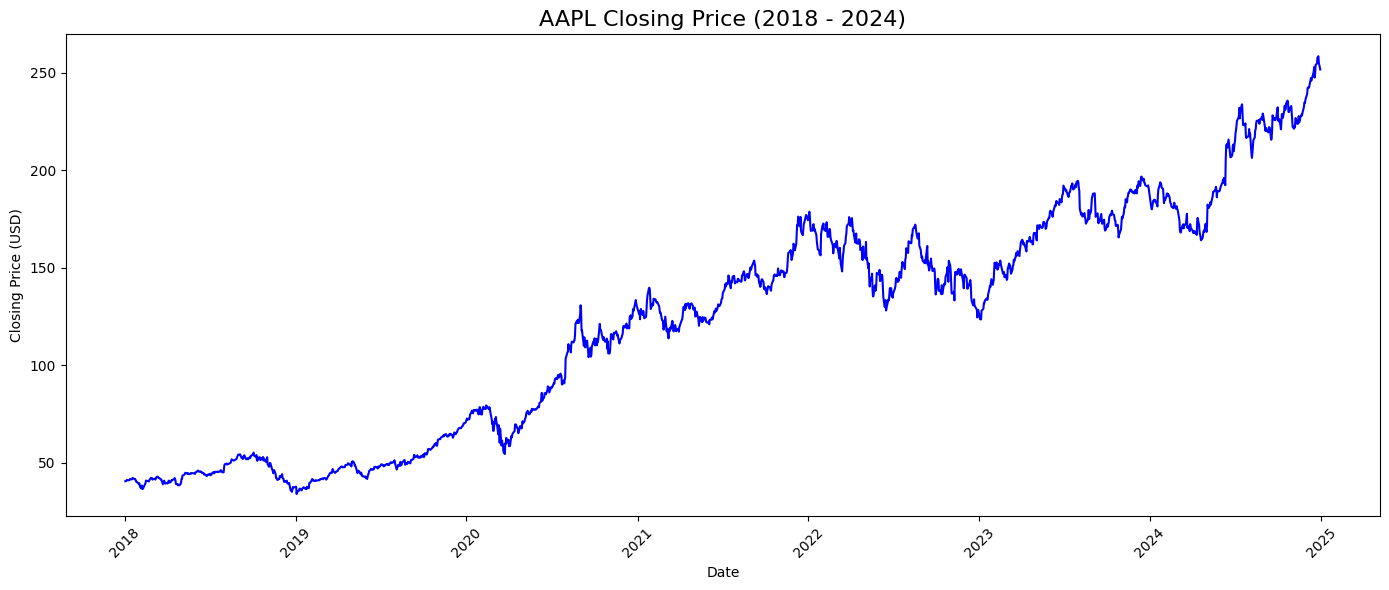

In [ ]:
# Set the plot style
# Reset index to make 'Date' a column
df_reset = df.reset_index()

# Just to be sure, check the columns
print(df_reset.columns)

# Plot using Seaborn
plt.figure(figsize=(14, 6))
# Access the 'Close' column using the MultiIndex
sns.lineplot(data=df_reset, x='Date', y=('Close', stock_symbol), color='blue')
plt.title(f'{stock_symbol} Closing Price (2018 - 2024)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Extract Close price and Check for missing values
# Extract the closing price series
close_series = df[('Close', stock_symbol)].copy()

# Check basic info
print("Shape of data:", close_series.shape)
print("Missing values:", close_series.isna().sum())

# If any missing values, fill them
close_series = close_series.fillna(method='ffill')


Shape of data: (1760,)
Missing values: 0


<ipython-input-4-3682349767>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_series = close_series.fillna(method='ffill')


In [ ]:
# Plot the Close Price (Optional Redo)

plt.figure(figsize=(14, 6))
plt.plot(close_series)
plt.title(f'{stock_symbol} - Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

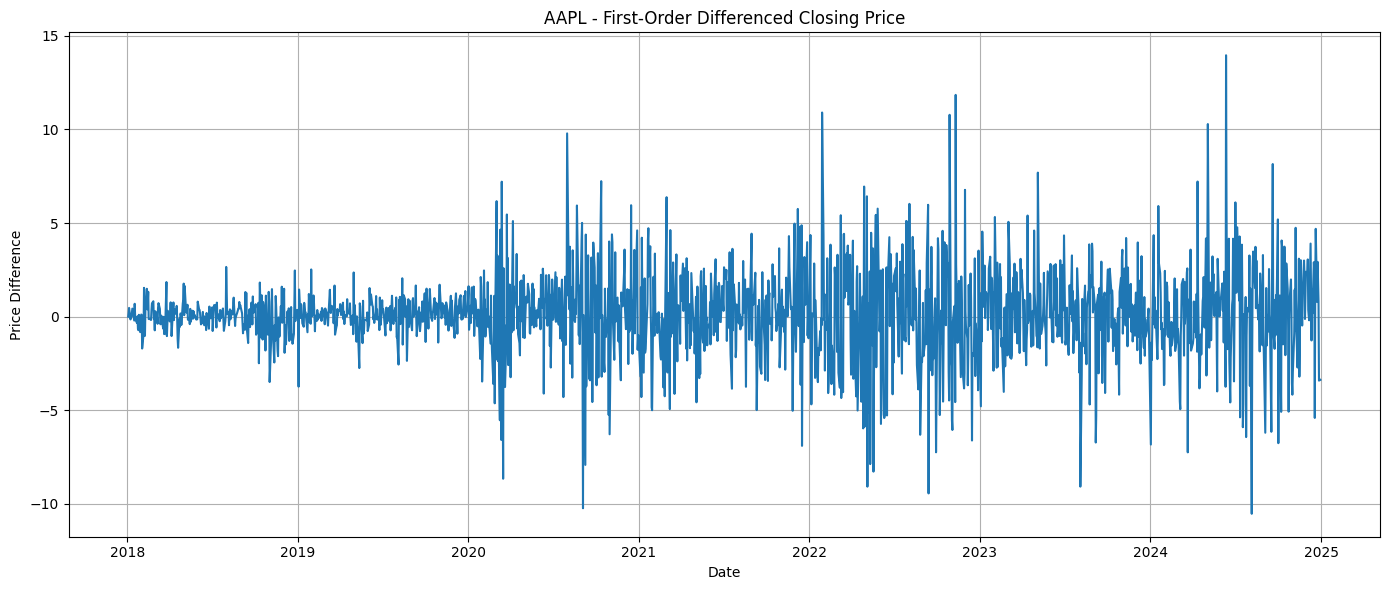


After Differencing:
ADF Statistic: -42.506514529036316
p-value: 0.0
Critical Values:
   1%: -3.4340751843300223
   5%: -2.8631854615325496
   10%: -2.5676459942198253
✅ Data is now stationary


In [ ]:
 # Perform ADF Test for Stationarity
# We’ll use adfuller from statsmodels:

from statsmodels.tsa.stattools import adfuller

# First-order differencing
diff_series = close_series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(14, 6))
plt.plot(diff_series)
plt.title(f'{stock_symbol} - First-Order Differenced Closing Price')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.grid(True)
plt.tight_layout()
plt.show()

# ADF Test after differencing
adf_result_diff = adfuller(diff_series)

print("\nAfter Differencing:")
print("ADF Statistic:", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
print("Critical Values:")
for key, value in adf_result_diff[4].items():
    print(f'   {key}: {value}')

if adf_result_diff[1] < 0.05:
    print("✅ Data is now stationary")
else:
    print("❌ Still not stationary—we might need second-order differencing")

In [ ]:
# Install pmdarima for Auto ARIMA
!pip install pmdarima --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.9 MB/s eta 0:00:00


In [ ]:
# run auto ARIMA to select model order

from pmdarima import auto_arima

# Auto ARIMA will try multiple (p, d, q) combinations and pick the best one
model_auto = auto_arima(close_series,
                        start_p=1, start_q=1,
                        max_p=5, max_q=5,
                        seasonal=False,      # This is a non-seasonal series
                        d=1,                 # Differencing already applied once
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(model_auto.summary())

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
#ARIMA MODEL
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA model - initial guess: (p=5, d=1, q=2)
model = ARIMA(close_series, order=(5, 1, 2))

# Fit the model
fitted_model = model.fit()

# Show summary
print(fitted_model.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      ('Close', 'AAPL')   No. Observations:                 1760
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3947.921
Date:                Thu, 12 Jun 2025   AIC                           7911.843
Time:                        14:02:58   BIC                           7955.623
Sample:                             0   HQIC                          7928.023
                               - 1760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0737      0.067      1.103      0.270      -0.057       0.205
ar.L2          0.8813      0.066     13.256      0.000       0.751       1.012
ar.L3         -0.0119      0.025     -0.483      0.6

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


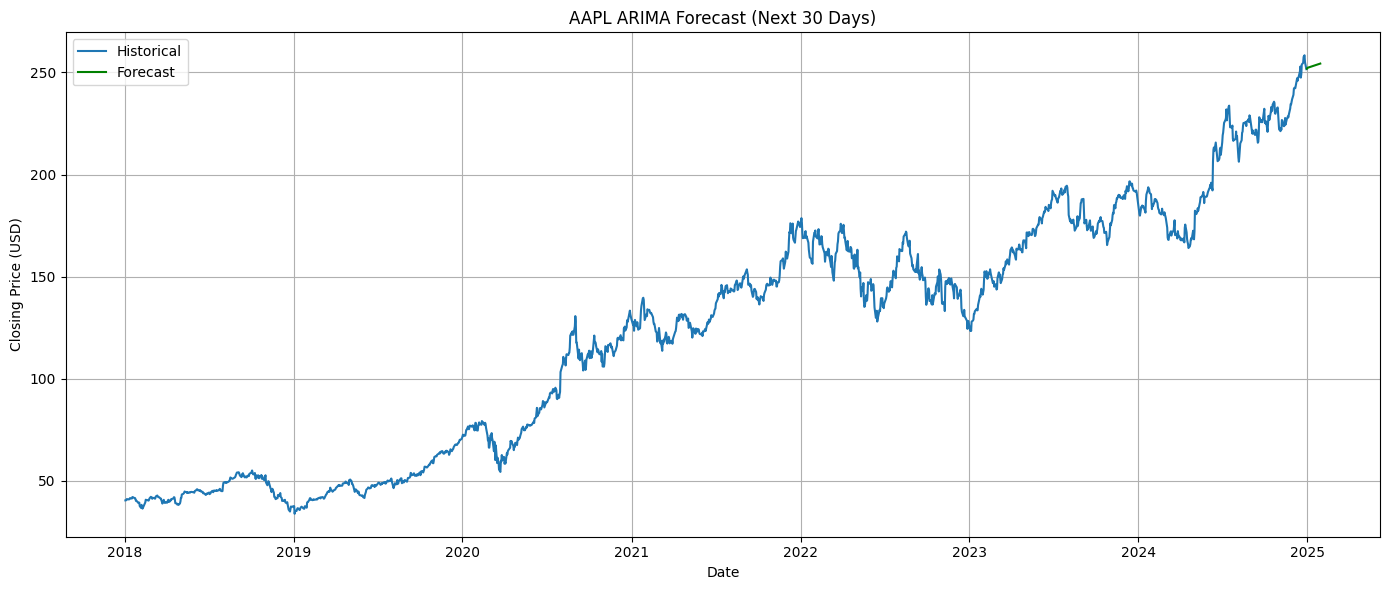

In [ ]:
# Forecast the next 30 days (ARIMA MODEL)
forecast = fitted_model.forecast(steps=30)

# Generate future date index
forecast_index = pd.date_range(start=close_series.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(close_series, label='Historical')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.title(f"{stock_symbol} ARIMA Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("arima.png")  # Save the plot
plt.show()


In [ ]:
from google.colab import files
files.download("arima.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# statsmodels should already be installed
!pip install statsmodels --quiet


In [ ]:
# SARIMA MODEL
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model
sarima_model = SARIMAX(close_series,
                       order=(1, 1, 1),          # ARIMA part (p,d,q)
                       seasonal_order=(1, 1, 1, 5),  # Seasonal part (P,D,Q,s)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the model
sarima_result = sarima_model.fit()

# Summary
print(sarima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                 ('Close', 'AAPL')   No. Observations:                 1760
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood               -3940.007
Date:                           Thu, 12 Jun 2025   AIC                           7890.015
Time:                                   13:50:27   BIC                           7917.343
Sample:                                        0   HQIC                          7900.118
                                          - 1760                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5373      0.450      1.194      0.233      -0.345       1.419
ma.L1         -0.5625      0.444     -1.266

In [ ]:
# Forecast next 30 days (SARIMA MODEL)
forecast_sarima = sarima_result.forecast(steps=30)

# Create date range for forecast
forecast_index = pd.date_range(start=close_series.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(close_series, label='Historical')
plt.plot(forecast_index, forecast_sarima, label='SARIMA Forecast', color='orange')
plt.title(f"{stock_symbol} SARIMA Forecast (30 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("sarima.png")
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
from google.colab import files
files.download("sarima.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install Prophet
!pip install prophet --quiet

# Import
from prophet import Prophet


In [ ]:
# Prepare the data
df_prophet = close_series.reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet expects columns: ds (date), y (value)

df_prophet.head()


ds          y
0 2018-01-02  40.426823
1 2018-01-03  40.419788
2 2018-01-04  40.607529
3 2018-01-05  41.069859
4 2018-01-08  40.917320

In [ ]:
# Initialize model
prophet_model = Prophet(daily_seasonality=True)

# Fit the model
prophet_model.fit(df_prophet)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn7dplfa/vuy1oeeu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn7dplfa/ee6tc8bw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11854', 'data', 'file=/tmp/tmpcn7dplfa/vuy1oeeu.json', 'init=/tmp/tmpcn7dplfa/ee6tc8bw.json', 'output', 'file=/tmp/tmpcn7dplfa/prophet_modelxwszck_x/prophet_model-20250612135106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:51:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:51:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


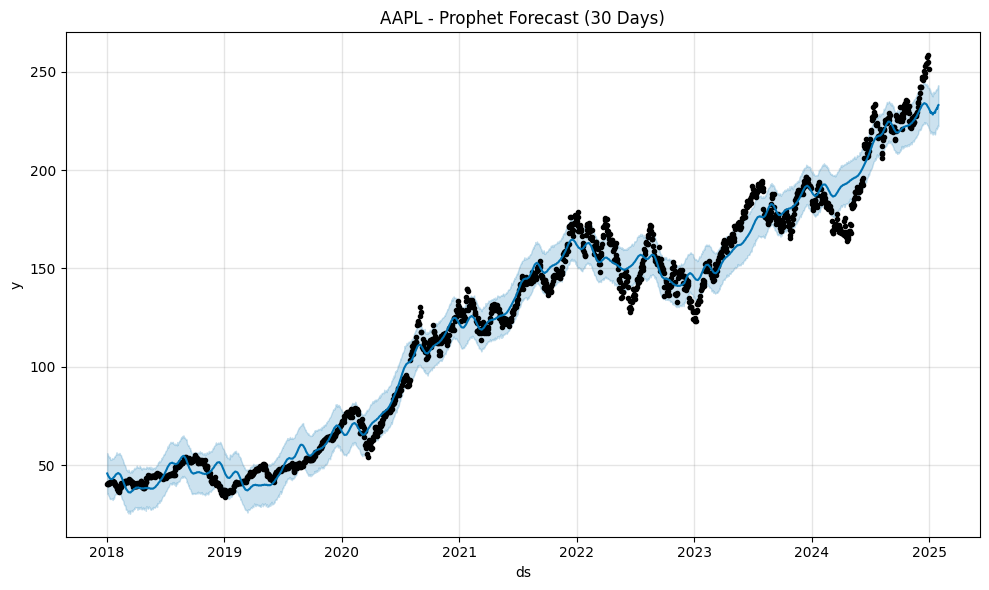

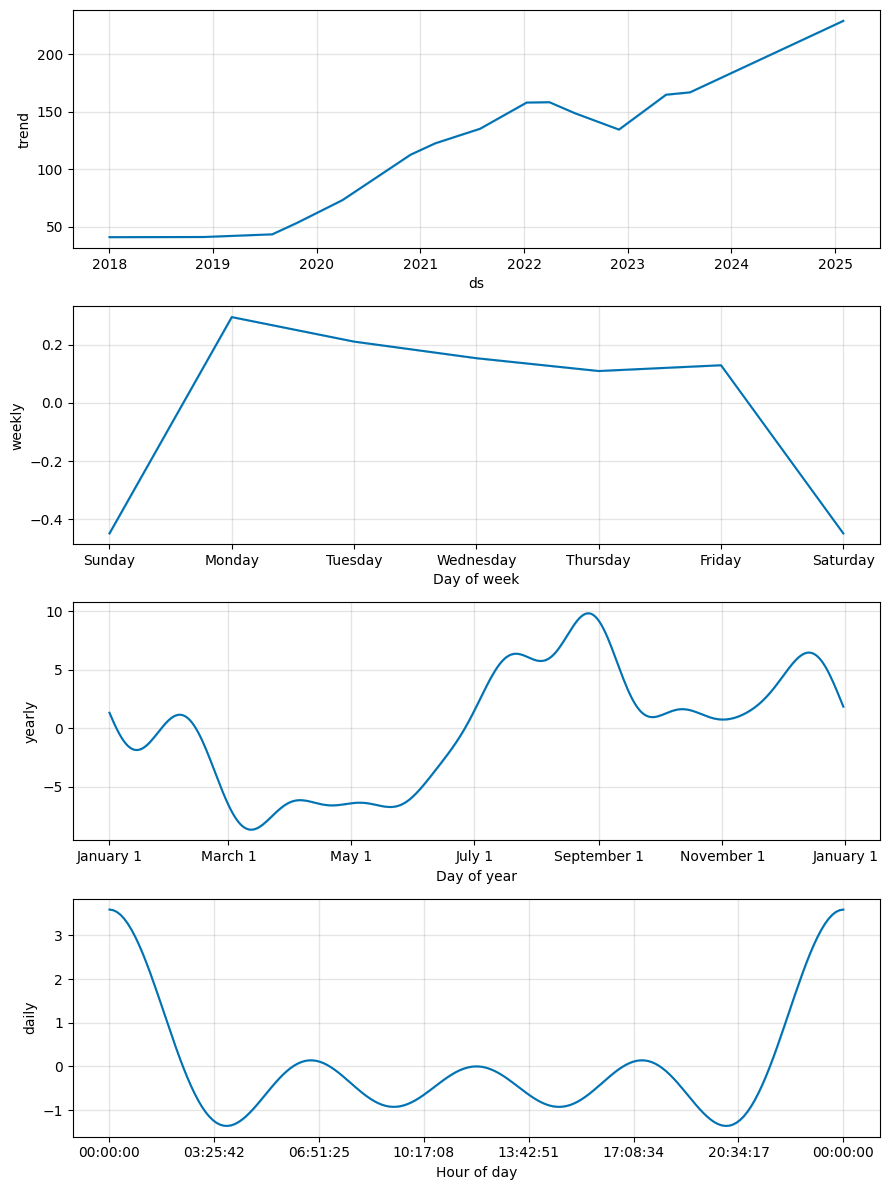

In [ ]:
# Create future dataframe (30 days ahead)
future = prophet_model.make_future_dataframe(periods=30)

# Forecast
forecast = prophet_model.predict(future)

# Plot forecast
fig1 = prophet_model.plot(forecast)
plt.title(f"{stock_symbol} - Prophet Forecast (30 Days)")
plt.tight_layout()
plt.show()

# Plot components (trend + seasonality)
fig2 = prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()


In [ ]:
fig1.savefig("prophet.png")


In [ ]:
from google.colab import files
files.download("prophet.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Install Libraries (if needed) (for LSTM)
# TensorFlow comes preinstalled in Colab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
#Prepare the Data for LSTM
# Use only closing prices and convert to numpy
data = close_series.values.reshape(-1, 1)

# Normalize between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
X, y = [], []
window_size = 60  # Use past 60 days to predict next day

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [ ]:
#Build and Train the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=5, batch_size=32)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0604
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 7.3323e-04
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 6.5116e-04
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 6.3694e-04
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 6.1756e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━

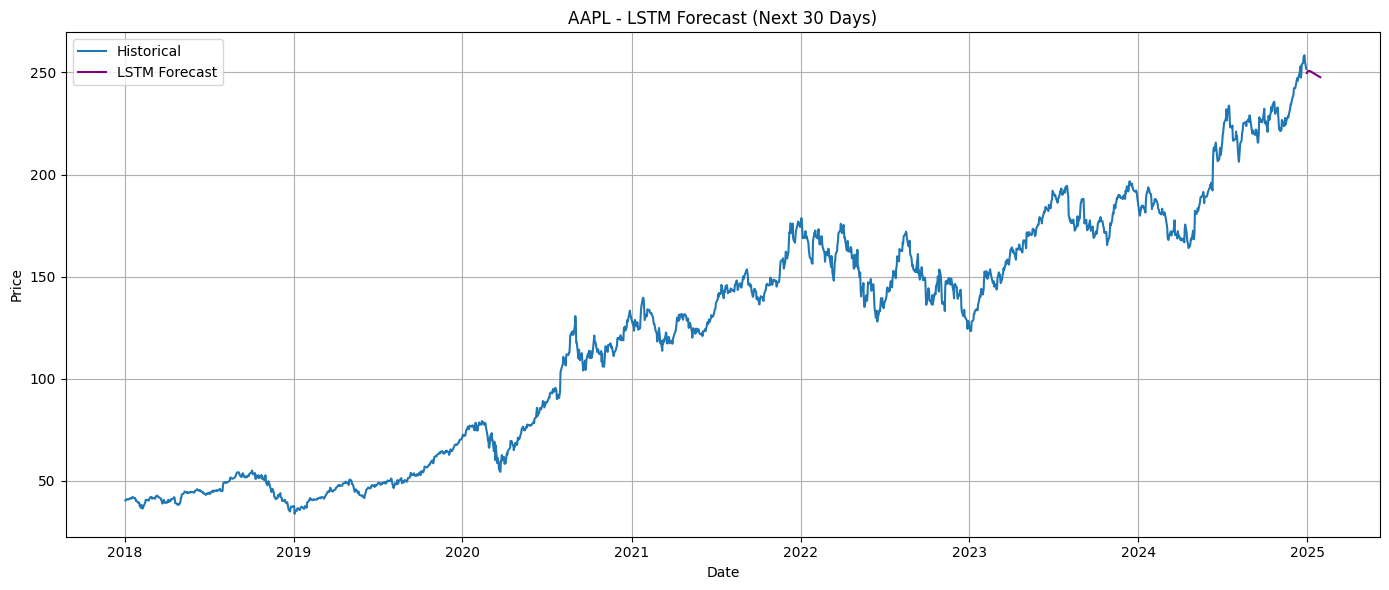

In [ ]:
#Forecast Next 30 Days (LSTM forecasting)
# Get last 60 values to start predicting
last_60 = scaled_data[-60:]
predictions = []

current_input = last_60.reshape(1, 60, 1)

for _ in range(30):
    next_pred = model.predict(current_input)[0][0]
    predictions.append(next_pred)

    # Update input window
    next_input = np.append(current_input[:, 1:, :], [[[next_pred]]], axis=1)
    current_input = next_input

# Reverse scaling
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create date index
future_dates = pd.date_range(start=close_series.index[-1] + pd.Timedelta(days=1), periods=30)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(close_series, label='Historical')
plt.plot(future_dates, predicted_prices, label='LSTM Forecast', color='purple')
plt.title(f"{stock_symbol} - LSTM Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("lstm.png")
plt.show()


In [ ]:
from google.colab import files
files.download("lstm.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#the model comparison pipeline
# Split the Data
#Training set = all data except last 30 days
#Test set = last 30 days (for evaluation)
# Split the data
train = close_series[:-30]
test = close_series[-30:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (1730,)
Test shape: (30,)


In [ ]:
#Re-fit ARIMA on Training Set and Forecast
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Fit ARIMA on train data
arima_model = ARIMA(train, order=(5, 1, 2))
arima_result = arima_model.fit()

# Forecast next 30 steps
arima_forecast = arima_result.forecast(steps=30)

# Evaluation
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
arima_mae = mean_absolute_error(test, arima_forecast)

print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"ARIMA MAE: {arima_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA RMSE: 18.0531
ARIMA MAE: 15.2812


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
#SARIMA Evaluation on Last 30 Days
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model on training data
sarima_model = SARIMAX(train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 5),  # Weekly seasonality
                       enforce_stationarity=False,
                       enforce_invertibility=False)

sarima_result = sarima_model.fit()

# Forecast next 30 days
sarima_forecast = sarima_result.forecast(steps=30)

# Evaluation
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
sarima_mae = mean_absolute_error(test, sarima_forecast)

print(f"SARIMA RMSE: {sarima_rmse:.4f}")
print(f"SARIMA MAE: {sarima_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA RMSE: 16.1573
SARIMA MAE: 13.6416


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
#Prophet Model Comparison
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prepare Prophet training data
df_train = train.reset_index()
df_train.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (value)

# Initialize and fit the model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(df_train)

# Create a future dataframe for the next 30 days
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Set 'ds' as index for forecast
forecast_indexed = forecast.set_index('ds')

# Intersect forecast and test date indexes
common_dates = forecast_indexed.index.intersection(test.index)

# Align predicted and actual values
prophet_forecast_values = forecast_indexed.loc[common_dates, 'yhat']
test_values_aligned = test.loc[common_dates]

# Evaluate
prophet_rmse = np.sqrt(mean_squared_error(test_values_aligned, prophet_forecast_values))
prophet_mae = mean_absolute_error(test_values_aligned, prophet_forecast_values)

print(f"Prophet RMSE: {prophet_rmse:.4f}")
print(f"Prophet MAE: {prophet_mae:.4f}")


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn7dplfa/q_bw5c38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcn7dplfa/6mxk0aan.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82580', 'data', 'file=/tmp/tmpcn7dplfa/q_bw5c38.json', 'init=/tmp/tmpcn7dplfa/6mxk0aan.json', 'output', 'file=/tmp/tmpcn7dplfa/prophet_model_iaiw25a/prophet_model-20250612135257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 15.7476
Prophet MAE: 14.4090


In [ ]:
#LSTM Evaluation on Last 30 Days
#Prepare Data
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Step 1: Normalize only training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))

# Step 2: Create sequences
X_train, y_train = [], []
window_size = 60

for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [ ]:
#Train the LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(50))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
#Predict the Next 30 Days
# Start from last 60 points in training data
last_window = train_scaled[-60:]
predictions = []

current_input = last_window.reshape(1, 60, 1)

for _ in range(30):
    pred = lstm_model.predict(current_input, verbose=0)[0][0]
    predictions.append(pred)
    current_input = np.append(current_input[:, 1:, :], [[[pred]]], axis=1)

# Inverse transform to get back real price
lstm_preds = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()


In [ ]:
# Evaluate vs Actual (Test Set)
from sklearn.metrics import mean_squared_error, mean_absolute_error

lstm_rmse = np.sqrt(mean_squared_error(test, lstm_preds))
lstm_mae = mean_absolute_error(test, lstm_preds)

print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")


LSTM RMSE: 23.8622
LSTM MAE: 20.9896


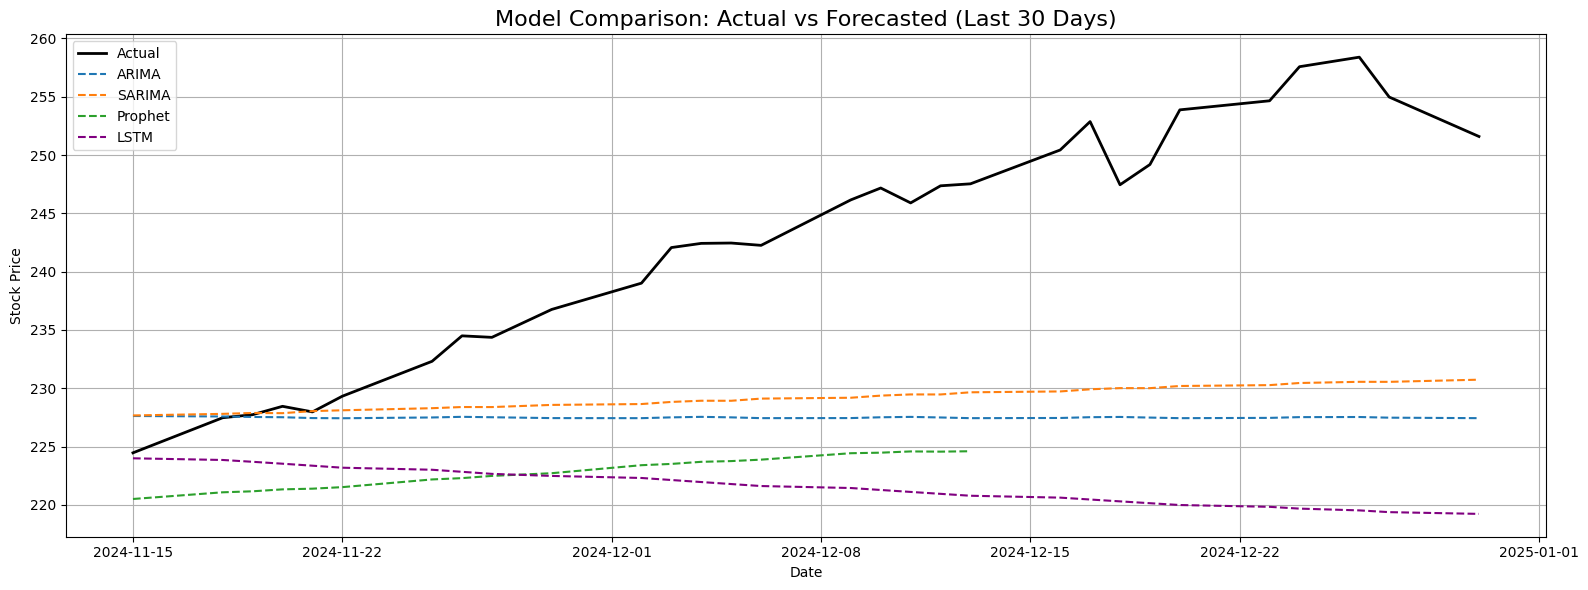

In [ ]:
#Plot Actual vs Forecasted (Last 30 Days)
# Convert test index to match forecasted values
dates = test.index

# Plot actual vs all models
plt.figure(figsize=(16, 6))
plt.plot(dates, test, label='Actual', linewidth=2, color='black')
plt.plot(dates, arima_forecast, label='ARIMA', linestyle='--')
plt.plot(dates, sarima_forecast, label='SARIMA', linestyle='--')
plt.plot(common_dates, prophet_forecast_values, label='Prophet', linestyle='--')
plt.plot(dates, lstm_preds, label='LSTM', linestyle='--', color='purple')

plt.title('Model Comparison: Actual vs Forecasted (Last 30 Days)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()